In [1]:
pip install hickle

In [2]:
from numpy import *
import pdb
import pickle
import scipy.io
import sys
import hickle as hkl

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

from matplotlib import animation

# p.switch_backend('newbackend')

import jax
import jax.numpy as np
from jax import jit, vmap, jacfwd, grad
import jax.random as randoms
from jax.example_libraries import optimizers
from jax.nn import sigmoid, softplus, relu
from jax import lax
# from jax.ops import index, index_add, index_update
from jax.tree_util import tree_map, tree_reduce
from jax.example_libraries.stax import Dense, Conv, Relu, MaxPool, Flatten, Softmax

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# ! sudo apt-get install texlive-latex-recommended
# ! sudo apt install texlive-latex-extra
# ! sudo apt install dvipng
# !apt install cm-super

# # plt.rcParams.update(plt.rcParamsDefault)
# # plt.rc('font', family='serif')
# # plt.rcParams.update({
# #                       "text.usetex": True,
# #                       "font.family": "serif",
# #                       'text.latex.preamble': r'\usepackage{amsmath}',
# #                       'font.size': 20,
# #                       'lines.linewidth': 3,
# #                       'axes.labelsize': 22,  # fontsize for x and y labels (was 10)
# #                       'axes.titlesize': 24,
# #                       'xtick.labelsize': 20,
# #                       'ytick.labelsize': 20,
# #                       'legend.fontsize': 20,
# #                       'axes.linewidth': 2})

In [4]:
shape_std=shape
def shape(A):
    if isinstance(A, ndarray):
        return shape_std(A)
    else:
        return A.shape()

size_std = size
def size(A):
    if isinstance(A, ndarray):
        return size_std(A)
    else:
        return A.size()

det = linalg.det

def new_speeds(m1, m2, v1, v2):
    new_v2 = (2*m1*v1 + v2*(m2-m1))/(m1+m2)
    new_v1 = new_v2 + (v2 - v1)
    return new_v1, new_v2


def norm(x):
    return sqrt((x**2).sum())

def sigmoid(x):
    return 1./(1.+exp(-x))

In [5]:
SIZE=10

In [6]:
def bounce_n(T=128, n=2, r=None, m=None):
    # if r==None: r=array([1.2]*n)
    if m==None: m=array([1]*n)
    # r is to be rather small.
    X=zeros((T, n, 2), dtype='float')
    v = random.randn(n,2)
    v = v / norm(v)*.5
    good_config=False
    while not good_config:
        x = 2+random.rand(n,2)*8
        good_config=True
        for i in range(n):
            for z in range(2):
                if x[i][z]-r[i]<0:      good_config=False
                if x[i][z]+r[i]>SIZE:     good_config=False

        # that's the main part.
        for i in range(n):
            for j in range(i):
                if norm(x[i]-x[j])<r[i]+r[j]:
                    good_config=False


    eps = .005
    # eps = .05
    for t in range(T):
        # for how long do we show small simulation

        for i in range(n):
            X[t,i]=x[i]

        for mu in range(int(1/eps)):

            for i in range(n):
                x[i]+=eps*v[i]

            for i in range(n):
                for z in range(2):
                    if x[i][z]-r[i]<0:  v[i][z]= abs(v[i][z]) # want positive
                    if x[i][z]+r[i]>SIZE: v[i][z]=-abs(v[i][z]) # want negative


            for i in range(n):
                for j in range(i):
                    if norm(x[i]-x[j])<r[i]+r[j]:
                        # the bouncing off part:
                        w    = x[i]-x[j]
                        w    = w / norm(w)

                        v_i  = dot(w.transpose(),v[i])
                        v_j  = dot(w.transpose(),v[j])

                        new_v_i, new_v_j = new_speeds(m[i], m[j], v_i, v_j)

                        v[i]+= w*(new_v_i - v_i)
                        v[j]+= w*(new_v_j - v_j)

    return X

def ar(x,y,z):
    return z/2+arange(x,y,z,dtype='float')

def matricize(X,res,r=None):

    T, n= shape(X)[0:2]
    # if r==None: r=array([1.2]*n)

    A=zeros((T,res,res), dtype='float')

    [I, J]=meshgrid(ar(0,1,1./res)*SIZE, ar(0,1,1./res)*SIZE)

    for t in range(T):
        for i in range(n):
            A[t]+= exp(-(  ((I-X[t,i,0])**2+(J-X[t,i,1])**2)/(r[i]**2)  )**4    )

        A[t][A[t]>1]=1
    return A

def bounce_mat(res, n=2, T=128, r =None):
    if r==None: r=array([1.2]*n)
    x = bounce_n(T,n,r);
    A = matricize(x,res,r)
    return A,X

def bounce_vec(res, n=2, T=128, r =None, m =None):
    if r==None: r=array([1.2]*n)
    x = bounce_n(T,n,r,m);
    V = matricize(x,res,r)
    return V.reshape(T, res**2), x

# make sure you have this folder
logdir = './sample'
def show_sample(V):
    T   = len(V)
    res = int(sqrt(shape(V)[1]))
    for t in range(T):
        plt.imshow(V[t].reshape(res,res),cmap=matplotlib.cm.Greys_r)
        # Save it
        fname = logdir+'/'+str(t)+'.png'
        plt.savefig(fname)


def generate_data(T, N, res):
    print('T={:d}, N={:d}'.format(T,N))


    dat=zeros((N,T,res*res), dtype=float32)
    x = zeros((N,T,3,2),dtype=float32) # ball locations
    print(dat.shape)
    for i in range(N):
        print(i)
        dat[i,:,:], x[i,:,:,:] = bounce_vec(res=res, n=3, T=T)
    hkl.dump(dat, 'training.hkl', mode='w', compression='gzip')
    hkl.dump(x, 'training_locs.hkl', mode='w', compression='gzip')

    Nv=int(N/20)
    dat=zeros((Nv,T,res*res), dtype=float32)
    x = zeros((Nv,T,3,2),dtype=float32) # ball locations
    for i in range(Nv):
        print(i)
        dat[i,:,:], x[i,:,:,:] = bounce_vec(res=res, n=3, T=T)
    hkl.dump(dat, 'val.hkl', mode='w', compression='gzip')
    hkl.dump(x, 'val_locs.hkl', mode='w', compression='gzip')

    Nt=int(N/20)
    dat=zeros((Nt,T,res*res), dtype=float32)
    x = zeros((Nt,T,3,2),dtype=float32) # ball locations
    for i in range(Nt):
        print(i)
        dat[i,:,:], x[i,:,:,:] = bounce_vec(res=res, n=3, T=T)
    hkl.dump(dat, 'test.hkl', mode='w', compression='gzip')
    hkl.dump(x, 'test_locs.hkl', mode='w', compression='gzip')



In [7]:
num_steps = 30000
num_seq = 1
res = 64

In [8]:
generate_data(num_steps, num_seq, res)

T=30000, N=1
(1, 30000, 4096)
0


In [9]:
data_ball = hkl.load('training.hkl').reshape(num_steps, res, res)[...,None]
data_ball = np.array(data_ball)

In [10]:
def pytree_dot(x, y):
    partial_dot = tree_map(lambda arr1, arr2: np.sum(arr1 * arr2), x, y)
    return tree_reduce(lax.add, partial_dot)

In [11]:
def mFF_CNN(conv_size, layers, freqs, activation = np.tanh):
# def mFF_CNN(conv_size, layers, freqs, activation = relu):
    ''' Multi-scale Fourier features MLP with weight normalization'''
    # Define input encoding function
    def input_encoding(x, w):
        out = np.hstack([np.sin(np.dot(x, w)),
                         np.cos(np.dot(x, w))])
        return out
    # Define linear layer
    def linear(x, w, b):
        return np.dot(x, w) + b

    # Initialize Fourier embedding weights (non-trainable)
    key, *keys = randoms.split(randoms.PRNGKey(0), len(freqs)+1)
    init_W = lambda key, freq: freq*randoms.normal(key, (layers[0], layers[1]//2))
    wFF = vmap(init_W)(*(np.array(keys), np.array(freqs)))

    # CNN init and apply functions
    init_conv1, apply_conv1 = Conv(conv_size[0], (5, 5), (2, 2), padding="VALID")
    init_conv2, apply_conv2 = Conv(conv_size[1], (5, 5), (2, 2), padding="SAME")
    init_conv3, apply_conv3 = Conv(conv_size[2], (5, 5), (2, 2), padding="SAME")

    # Define init function
    def init(rng_key, input_shape):
        # Initialize CNN params
        keys = randoms.split(rng_key, 3)
        out_shape, conv1_params = init_conv1(keys[0], input_shape)
        out_shape, conv2_params = init_conv2(keys[1], out_shape)
        out_shape, conv3_params = init_conv2(keys[2], out_shape)
        cnn_params = (conv1_params, conv2_params, conv3_params)
        # Initialize MLP params
        def init_layer(key, d_in, d_out):
            k1, k2 = randoms.split(key)
            W = randoms.normal(k1, (d_in, d_out))
            b = np.zeros(d_out)
            return W, b
        key, *keys = randoms.split(rng_key, len(layers))
        mlp_params = list(map(init_layer, keys, layers[1:-1], layers[2:]))
        return (cnn_params, mlp_params)
    # Define apply function
    def apply(params, inputs):
        inputs = inputs[None,:]
        cnn_params, mlp_params = params
        # Convolutional layers
        conv1 = apply_conv1(cnn_params[0], inputs)
        conv2 = apply_conv2(cnn_params[1], conv1)
        conv3 = apply_conv3(cnn_params[2], conv2)
        conv3 = conv3
        # Fourier features embedding
        inputs = np.reshape(conv3, (conv3.shape[0], -1))
        H = vmap(input_encoding, in_axes=(None,0))(inputs, wFF)
        # MLP
        for W, b in mlp_params[:-1]:
            H = vmap(linear, in_axes=(0,None,None))(H, W, b)
            H = activation(H)
        W, b = mlp_params[-1]
        H = vmap(linear, in_axes=(0,None,None))(H, W, b)
        return H.flatten()
    return init, apply

In [12]:
class DataGenerator(data.Dataset):
    def __init__(self, images,
                 batch_size=128,
                 rng_key=randoms.PRNGKey(1234)):
        'Initialization'
        self.images = images
        self.N = images.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, images):
        'Generates data containing batch_size samples'
        idx = randoms.randint(key, minval=0, maxval=self.N - 4*self.batch_size - 8, shape=(1,))
        idx = np.arange(self.batch_size) + idx
        inputs = np.concatenate([images[idx, ...],
                                 images[idx+4,...]],axis = -1)
        return inputs

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = randoms.split(self.key)
        frame = self.__data_generation(self.key, self.images)
        return frame

In [13]:
def weights_matrix(neig):
    # vec = np.flip(10.0*(np.arange(neig)+1))
    # vec = 50.0*(np.arange(neig)+1)
    # mat = np.diag(vec)
    mat = np.eye(neig)
    return mat


In [14]:
class SPIN:
    def __init__(self, operator, conv_size, input_shape,  layers, freqs):

        # Callable operator function
        self.operator = operator

        # Network initialization and evaluation functions
        self.net_init, self.net_apply = mFF_CNN(conv_size, layers, freqs)

        # Initialize network parameters
        params = self.net_init(randoms.PRNGKey(0), input_shape)

        # Optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-4, decay_steps=1000, decay_rate=0.999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.rmsprop(lr)
        self.opt_state = self.opt_init(params)


        # Number of eigenvalues
        self.neig = len(freqs)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []
        self.evals_log = []
        self.weights_log = []

    def net_u(self, params, inputs):
        outputs = vmap(self.net_apply, in_axes=(None, 0))(params, inputs)
        return outputs


    def evaluate_spin(self, params, inputs):
        # Fetch batch
        n = inputs.shape[0]
        # Evaluate model
        u = self.net_u(params, inputs)
        sigma = np.dot(u.T, u)/n
        # Cholesky
        chol = np.linalg.cholesky(sigma)
        choli = np.linalg.inv(chol) # $L^{-1}$
        # Operator
        operator = self.operator(self.net_u, params, inputs)
        pi = np.dot(operator.T, u)/n # $\Pi$
        rq = np.dot(choli, np.dot(pi, choli.T)) # $\Lambda$
        return (u, choli, pi, rq, operator)

    def residuals(self, params, inputs):
        outputs = self.evaluate_spin(params, inputs)
        u, choli, _, rq, op = outputs
        dl = np.diag(np.diag(rq))
        residuals = np.dot(op, choli.T) - np.dot(np.dot(u, choli.T),dl)
        # residuals = rq - dl

        evals = np.diag(rq)
        loss_residual = np.mean(residuals**2, axis=0)
        # loss_trace = -1.0*evals
        weight_tr = weights_matrix(self.neig)
        evals = np.dot(weight_tr, evals)
        # loss_trace = np.array([-1.0*np.sum(evals)])
        loss_trace = np.array([np.sum(evals)])
        return np.hstack([loss_residual, loss_trace])

    @partial(jit, static_argnums=(0,))
    def loss(self, params, inputs, weights):
        losses = self.residuals(params, inputs)
        return np.dot(weights, losses)/self.neig

    # Define a jit-compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, inputs, weights):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, inputs, weights)
        opt_state = self.opt_update(i, gradients, opt_state)
        return opt_state

    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000, ntk_weights = False):
        batch = iter(dataset)
        pbar = trange(nIter)
        # Initialize NTK weights
        if ntk_weights:
            params = self.get_params(self.opt_state)
            weights = self.update_NTK_weights(params, next(batch))
        else:
            weights = np.ones(1 + self.neig)
        # Main training loop
        for it in pbar:
            inputs = next(batch)
            # Run one gradient descent update
            self.opt_state = self.step(next(self.itercount),
                                       self.opt_state,
                                       inputs,
                                       weights)
            # Logger
            if it % 250 == 0:
                params = self.get_params(self.opt_state)
                losses = self.residuals(params, inputs)
                evals, _, _ = self.eigenpairs(params, inputs)
                self.loss_log.append(losses)
                self.evals_log.append(evals)
                # pbar.set_postfix({'Loss': np.sum(losses)/(2*self.neig)})
                pbar.set_postfix({'Loss': np.sum(losses)/(1 + self.neig)})
                if ntk_weights:
                    weights = self.update_NTK_weights(params, inputs)
                    self.weights_log.append(weights)


    # Evaluates predictions at test points
    @partial(jit, static_argnums=(0,))
    def eigenpairs(self, params, inputs):
        outputs = self.evaluate_spin(params, inputs)
        u, choli, _, rq, _ = outputs
        evals = np.diag(rq)
        efuns = np.matmul(u, choli.T)
        return evals, efuns, rq

    @partial(jit, static_argnums=(0,))
    def update_NTK_weights(self, params, inputs):
        def body_fn(i, state):
            r_fn = lambda theta: self.residuals(theta, inputs)[i]
            diag = grad(r_fn)(params)
            trace = pytree_dot(diag, diag)
            # state = index_update(state, index[i], trace)
            state = state.at[i].set(trace)
            return state
        # traces = lax.fori_loop(0, 2*self.neig, body_fn, np.zeros(2*self.neig))
        traces = lax.fori_loop(0, 1 + self.neig, body_fn, np.zeros(1 + self.neig))
        weights = np.sum(traces)/traces
        return weights**0.5


In [15]:
def SFA(u_fn, params, inputs):
    outputs = u_fn(params, inputs)
    n = outputs.shape[0]
    vec = np.ones(n)
    vec_ = np.ones(n-1)
    mat_1 = 2.0 * np.diag(vec)
    mat_2 = -1.0 * np.diag(vec_,k = -1)
    mat_3 = -1.0 * np.diag(vec_,k = 1)
    coeff = mat_1 + mat_2 + mat_3
    coeff = coeff.at[0,0].set(1)
    coeff = coeff.at[-1,-1].set(1)
    # ind = 2.0 * np.eye(n)
    # coeff = coeff + ind
    return np.dot(coeff, outputs)


In [16]:
neig = 13

dataset = DataGenerator(data_ball, batch_size = 512)

In [17]:
input_shape = (-1, 64, 64, 2)
conv_size = [32, 32, 32]
# layers = [2048, 512, 256, 1]
layers = [2048, 256, 1]
# alpha = 1.2
# freqs = list(0.2*(np.arange(neig)+1)**alpha)
freqs = list(1.0*(np.arange(neig)+1)**0.0)
model = SPIN(SFA, conv_size, input_shape, layers, freqs)
print('Frequencies at initialization:\n{}'.format(freqs))

Frequencies at initialization:
[Array(1., dtype=float32, weak_type=True), Array(1., dtype=float32, weak_type=True), Array(1., dtype=float32, weak_type=True), Array(1., dtype=float32, weak_type=True), Array(1., dtype=float32, weak_type=True), Array(1., dtype=float32, weak_type=True), Array(1., dtype=float32, weak_type=True), Array(1., dtype=float32, weak_type=True), Array(1., dtype=float32, weak_type=True), Array(1., dtype=float32, weak_type=True), Array(1., dtype=float32, weak_type=True), Array(1., dtype=float32, weak_type=True), Array(1., dtype=float32, weak_type=True)]


In [18]:
ntk_weights = True
model.train(dataset, nIter = 10000, ntk_weights = ntk_weights)

100%|██████████| 10000/10000 [06:44<00:00, 24.69it/s, Loss=0.023447309]


In [19]:
opt_params = model.get_params(model.opt_state)

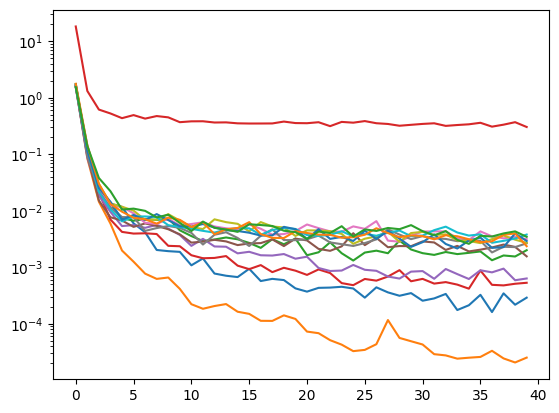

In [20]:
plt.plot(model.loss_log)
plt.yscale('log')

Text(0.5, 0, 'Iteration')

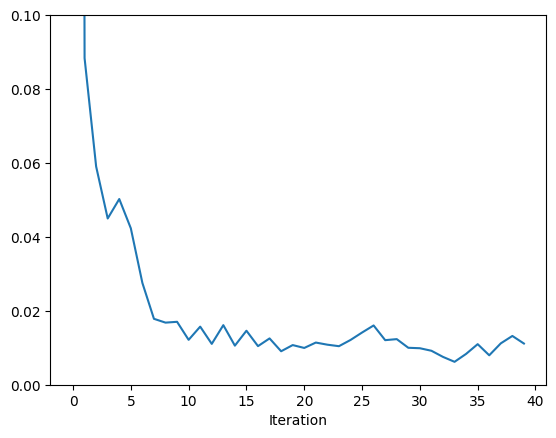

In [21]:
evals_log = model.evals_log
evals_log = np.array(evals_log)
plt.plot(evals_log[:,0])
plt.ylim([0.0,0.1])
plt.xlabel('Iteration')


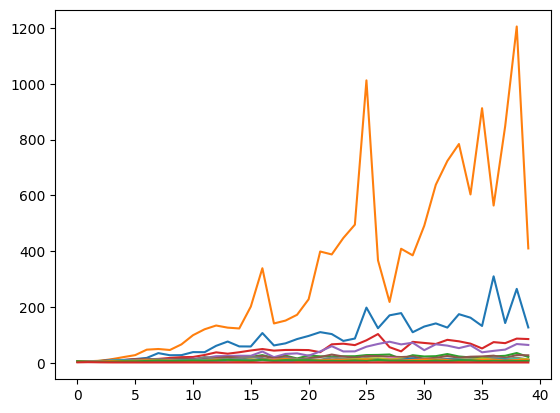

In [22]:
plt.plot(model.weights_log)


[0.05548283 0.08339071 0.28462616 0.14311816 0.29213372 0.7182456
 0.6051938  0.5652298  0.35938656 0.4579343  0.3906763  0.42658418
 0.43602866]


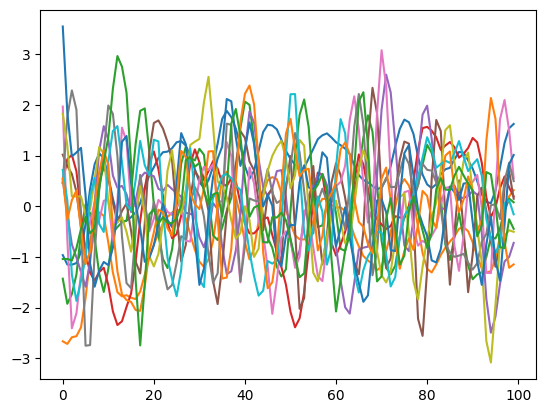

In [23]:
batch_size = 100
idx = 4 * np.arange(batch_size)
x_1 = data_ball[idx,...]
x_2 = data_ball[idx+4,...]
x_star = np.concatenate([x_1, x_2], axis = -1)
evals, efuns, rq = model.eigenpairs(opt_params, x_star)
print(evals)
plt.plot(np.arange(batch_size), efuns)

In [24]:
T = 30000
batch_size = 512
delta_t = 1000
num_frame = (T -1 - batch_size + delta_t)//delta_t

idx = 2*np.arange(batch_size)
idx_2 = (np.arange(num_frame)+1)*delta_t

A = np.zeros([64,64,neig])
B = np.zeros([64,64,neig])

# @partial(jit, static_argnums=(0,))
def plotting(A, B, efuns, x_star, j):
    a = np.argmax(efuns[:,j])
    b = np.argmin(efuns[:,j])
    D = x_star[a,:,:,0]
    E = x_star[b,:,:,0]
    idx_nz_1 = np.nonzero(D)
    idx_nz_2 = np.nonzero(E)

    D = D.at[idx_nz_1[0], idx_nz_1[1]].set(1)
    E = E.at[idx_nz_2[0], idx_nz_2[1]].set(1)
    A = A.at[:,:,j].set(A[:,:,j] + D)
    B = B.at[:,:,j].set(B[:,:,j] - E)
    return A, B



for i in np.arange(num_frame):
    x_1 = data_ball[idx+idx_2[i],...]
    x_2 = data_ball[idx+idx_2[i]+2,...]
    x_star = np.concatenate([x_1, x_2], axis = -1)
    _, efuns, _ = model.eigenpairs(opt_params, x_star)
    for j in np.arange(neig):
        A, B = plotting(A, B, efuns, x_star, j)

C = A + B

# plt.figure(figsize = [4*6, 3*4])
# # for i in (np.arange(neig-1)+1):
# for i in (np.array([0,2,3,4])):
#     plt.subplot(1,6,i+1)
#     # plt.subplot((neig-1)//6+1,6,i)
#     plt.imshow(C[:,:,i])
#     plt.title('{}-th feature'.format(i))




[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


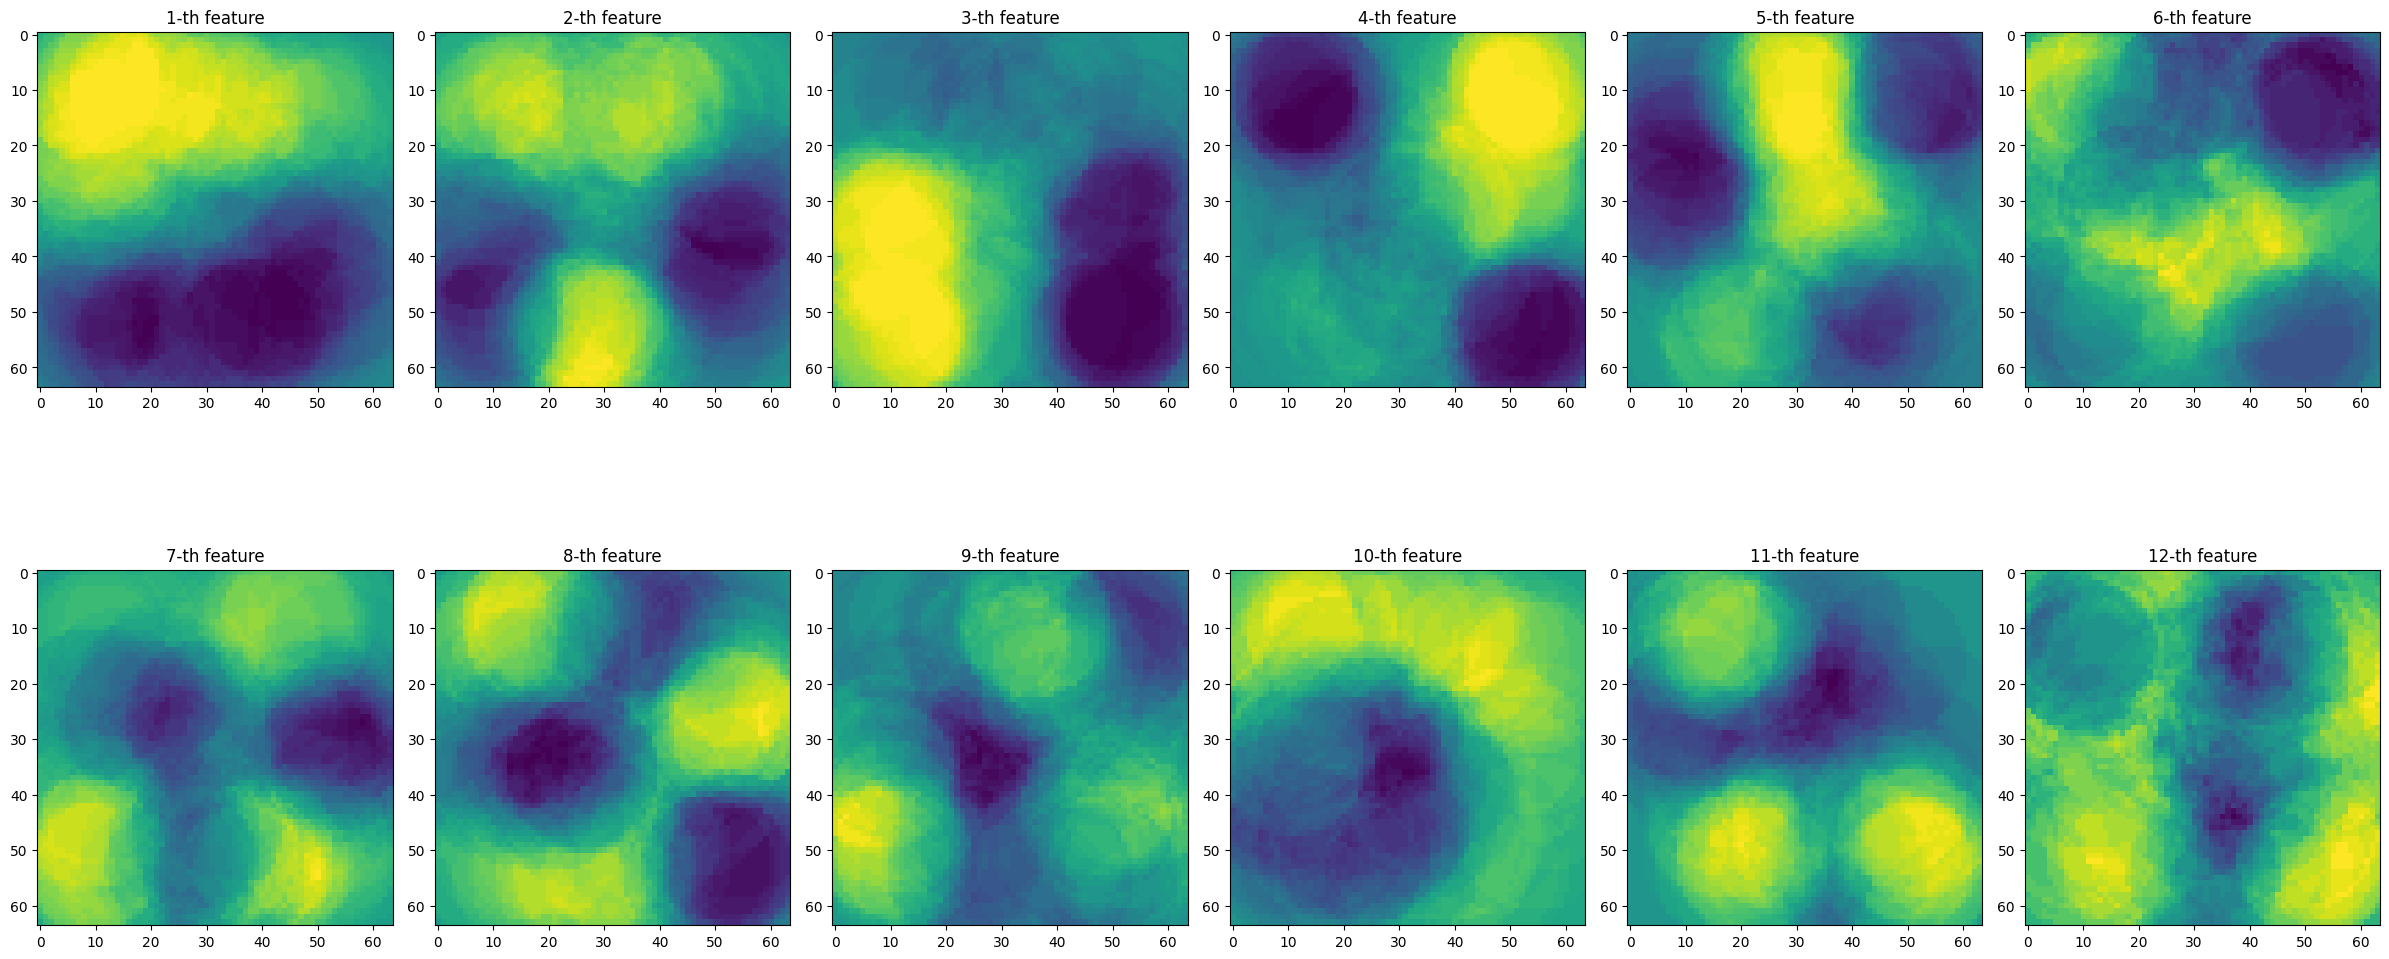

In [25]:
fig = plt.figure(figsize = [4*6, 3*4])
# for i in (np.arange(neig-1)+1):
lis = list([0,2,3,4,5,6,7,8,9,10,11,12])
print(lis)
for i in np.arange(neig-1):
    j = lis[i]
    plt.subplot(2,6,int(i+1))
    # plt.subplot((neig-1)//6+1,6,i)
    plt.imshow(C[:,:,j])
    plt.title('{}-th feature'.format(i+1))
plt.tight_layout()
# fig.savefig("SFA_balls" + ".pdf", bbox_inches='tight', dpi=600)